## Comprehensive guide for ingesting & exploring the Wikipedia Structured Contents dataset.
### This will show you how to load, explore, and analyze the structured JSON data.

In [1]:
!pip install -q ijson  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 4.6 MB/s eta 0:00:00


## Basic Imports

In [2]:
import pandas as pd
import json
from pathlib import Path
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import re
from collections import Counter, defaultdict
import numpy as np
import glob
import gc
from multiprocessing import Pool, cpu_count
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import logging
import ijson  # For incremental JSON parsing

## Load a file

In [3]:
# Set the base directory
base_path = Path('/kaggle/input/wikipedia-structured-contents/enwiki_namespace_0')

# List some files to load (you can load all if needed)
files_to_load = [
    'enwiki_namespace_0_0.jsonl'
]

pd.set_option('display.max_colwidth', 25)
pd.set_option('display.max_rows', 20)

# Read and combine JSONL files into a DataFrame
data = []
for file_name in files_to_load:
    file_path = base_path / file_name
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)


# Display some records
df.head(5)

,name,identifier,version,event,url,date_created,date_modified,is_part_of,in_language,license,description,sections,abstract,main_entity,additional_entities,infoboxes,image
0,Not Again SU,76716259,{'identifier': 122041...,{'identifier': 'fa3ca...,https://en.wikipedia....,2024-04-23T16:50:32Z,2024-04-23T16:53:55Z,{'identifier': 'enwik...,{'identifier': 'en'},[{'name': 'Creative C...,Student organization ...,"[{'type': 'section', ...",NaN,NaN,NaN,NaN,NaN
1,Mike Ross (Suits),76727681,{'identifier': 122057...,{'identifier': '22366...,https://en.wikipedia....,2024-04-24T17:12:05Z,2024-04-24T17:14:10Z,{'identifier': 'enwik...,{'identifier': 'en'},[{'name': 'Creative C...,An American Legal dra...,"[{'type': 'section', ...",REDIRECT List of Suit...,{'identifier': 'Q1253...,[{'identifier': 'Q125...,NaN,NaN
2,Second Polish republic,76744378,{'identifier': 122087...,{'identifier': '55262...,https://en.wikipedia....,2024-04-26T13:30:10Z,2024-04-26T13:30:10Z,{'identifier': 'enwik...,{'identifier': 'en'},[{'name': 'Creative C...,Country in Central an...,"[{'type': 'section', ...",REDIRECT #Second Poli...,NaN,NaN,NaN,NaN
3,Left-to-right script,76735997,{'identifier': 122071...,{'identifier': 'aae6c...,https://en.wikipedia....,2024-04-25T13:58:39Z,2024-04-25T13:58:39Z,{'identifier': 'enwik...,{'identifier': 'en'},[{'name': 'Creative C...,Convention of symbols...,"[{'type': 'section', ...",REDIRECT Writing syst...,NaN,NaN,NaN,NaN
4,1442 in France,58128987,{'identifier': 114535...,{'identifier': 'c4526...,https://en.wikipedia....,NaN,2023-03-18T18:38:51Z,{'identifier': 'enwik...,{'identifier': 'en'},[{'name': 'Creative C...,List of events in the...,"[{'type': 'section', ...",Events from the year ...,{'identifier': 'Q5629...,[{'identifier': 'Q562...,"[{'type': 'infobox', ...",NaN


In [5]:
# Display shape 

print("Shape:",df.shape)


# Display info
print("------------- Column Name ------------- ")

df.info()



Shape: (309509, 17)
------------- Column Name ------------- 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309509 entries, 0 to 309508
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   name                 309509 non-null  object
 1   identifier           309509 non-null  int64 
 2   version              309509 non-null  object
 3   event                309509 non-null  object
 4   url                  309509 non-null  object
 5   date_created         300 non-null     object
 6   date_modified        309509 non-null  object
 7   is_part_of           309509 non-null  object
 8   in_language          309509 non-null  object
 9   license              309509 non-null  object
 10  description          252651 non-null  object
 11  sections             309447 non-null  object
 12  abstract             309004 non-null  object
 13  main_entity          309128 non-null  object
 14  additional_entities  30

## Basic info about the dataset

In [11]:
# Print basic info about the dataset
print(f"Total number of articles: {len(df)}")
print(f"Data timespan: From {df['date_modified'].min()} to {df['date_modified'].max()}")
print(f"Number of articles with images: {df['image'].notnull().sum()} ({df['image'].notnull().sum()/len(df)*100:.2f}%)")
print(f"Number of articles with infoboxes: {df['infoboxes'].notnull().sum()} ({df['infoboxes'].notnull().sum()/len(df)*100:.2f}%)")

# Check null values across columns
null_counts = df.isnull().sum().sort_values(ascending=False)
null_percentage = (null_counts / len(df) * 100).round(2)
null_summary = pd.DataFrame({'Null Count': null_counts, 'Null Percentage': null_percentage})
display(null_summary)

Total number of articles: 309509
Data timespan: From 2008-06-16T22:08:47Z to 2024-08-06T09:10:36Z
Number of articles with images: 90607 (29.27%)
Number of articles with infoboxes: 212068 (68.52%)


,Null Count,Null Percentage
qid,309509,100.00
date_created,309209,99.90
image,218902,70.73
infoboxes,97441,31.48
description,56858,18.37
abstract,505,0.16
main_entity,381,0.12
additional_entities,376,0.12
sections,62,0.02
name,0,0.00


## Info about description coumn

In [6]:
# Distribution of Article Types
df['description'].value_counts().head(10)

description
Topics referred to by the same term    23387
Species of moth                         4754
Surname list                            4214
American college football season        3343
Species of beetle                       3033
Football league season                  2381
Military unit                           1960
Tennis tournament                       1798
American politician                     1697
United States historic place            1658
Name: count, dtype: int64

## Text Length Analysis

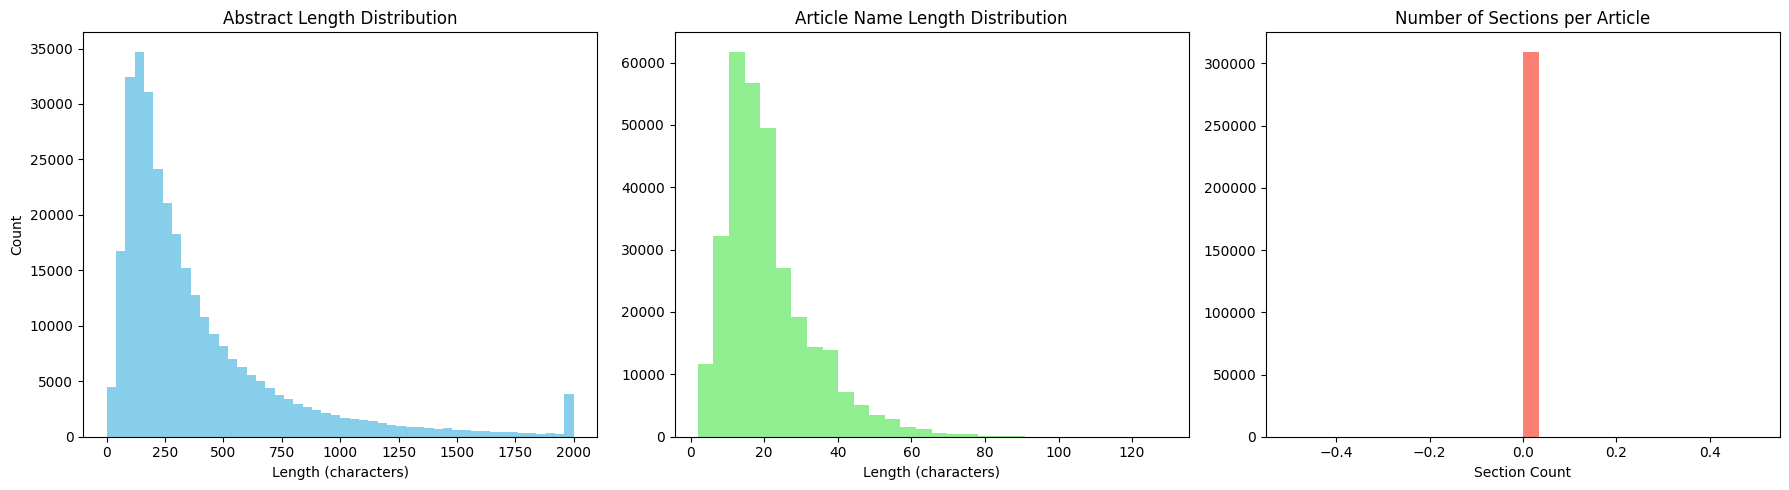

In [12]:
# Add columns for text lengths
df['abstract_length'] = df['abstract'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df['name_length'] = df['name'].apply(lambda x: len(x) if isinstance(x, str) else 0)
df['section_count'] = df['sections'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# Create visualizations
plt.figure(figsize=(18, 5))

# Abstract length distribution
plt.subplot(1, 3, 1)
plt.hist(df['abstract_length'].clip(0, 2000), bins=50, color='skyblue')
plt.title('Abstract Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Count')

# Article name length
plt.subplot(1, 3, 2)
plt.hist(df['name_length'], bins=30, color='lightgreen')
plt.title('Article Name Length Distribution')
plt.xlabel('Length (characters)')

# Number of sections
plt.subplot(1, 3, 3)
plt.hist(df['section_count'].clip(0, 50), bins=30, color='salmon')
plt.title('Number of Sections per Article')
plt.xlabel('Section Count')

plt.tight_layout()
plt.show()

## Topic Distribution Analysis

0         Unknown
1           Error
2         Unknown
3         Unknown
4           Error
           ...   
309504      Error
309505      Error
309506      Error
309507      Error
309508      Error
Name: main_entity_type, Length: 309509, dtype: object


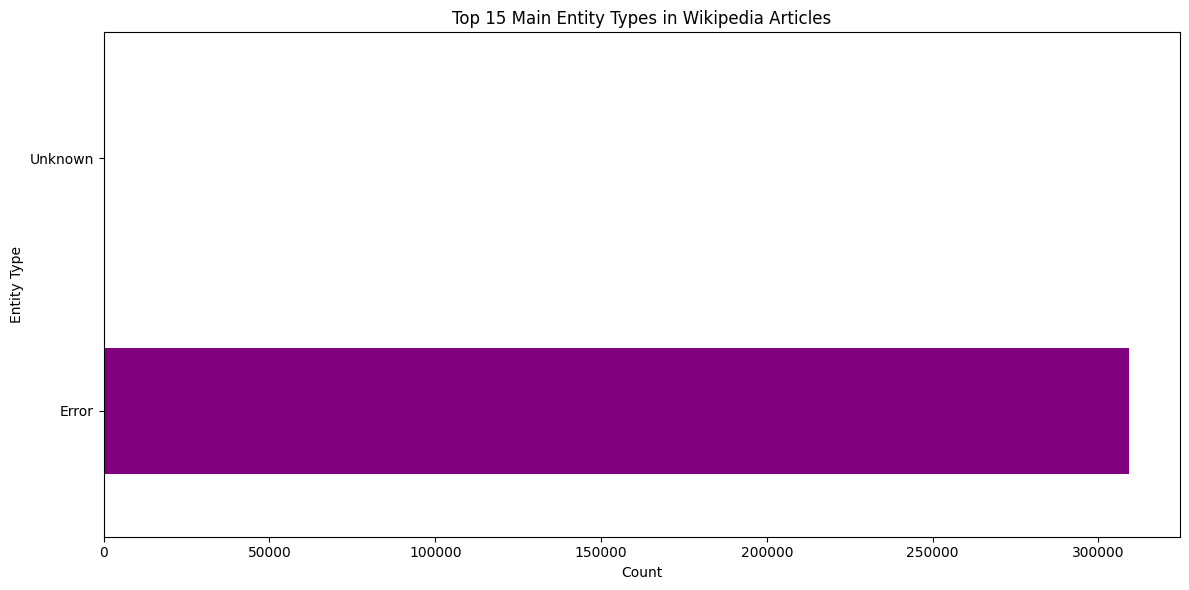

In [21]:
# Extract main entity types
def extract_entity_type(entity_str):
    if pd.isna(entity_str):
        return "Unknown"
    try:
        entity = eval(entity_str)
        if '@type' in entity:
            return entity['@type']
        return "Unspecified"
    except:
        return "Error"

# Apply extraction
df['main_entity_type'] = df['main_entity'].apply(extract_entity_type)
print(df['main_entity_type'])

# Plot top entity types
entity_counts = df['main_entity_type'].value_counts().head(15)
plt.figure(figsize=(12, 6))
entity_counts.plot(kind='barh', color='purple')
plt.title('Top 15 Main Entity Types in Wikipedia Articles')
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.tight_layout()
plt.show()

## Time Series Analysis of Articles

/tmp/ipykernel_31/1815805891.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['modification_year_month'] = df['date_modified'].dt.to_period('M')


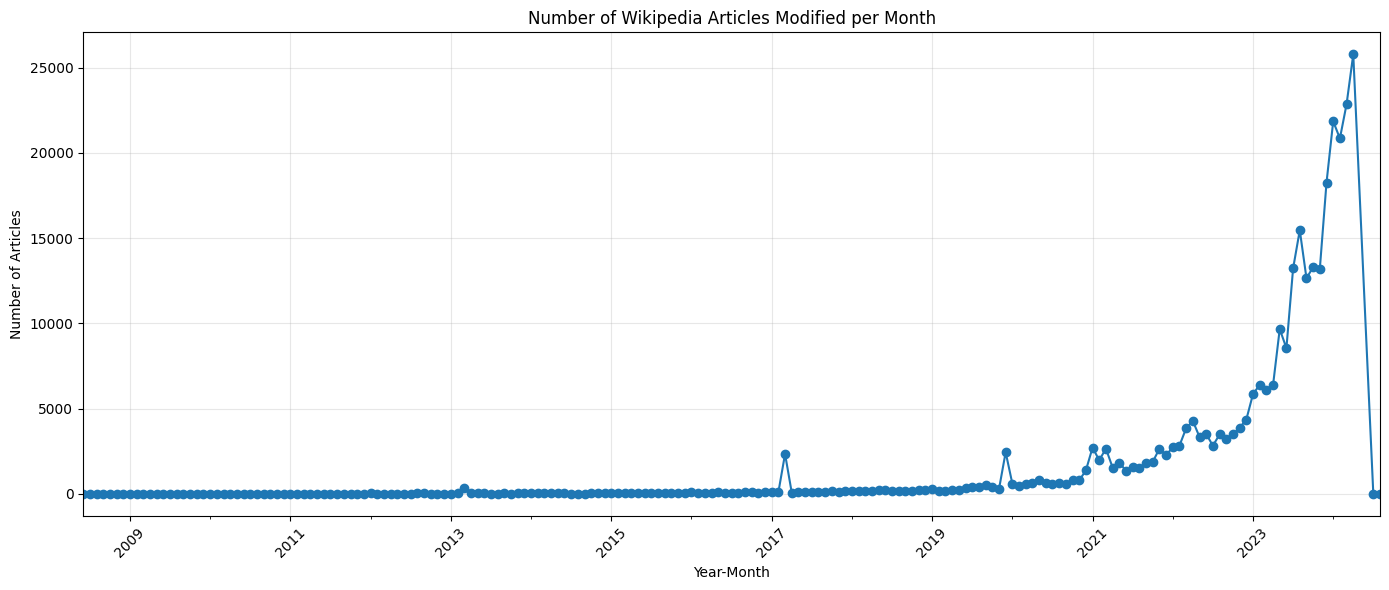

In [14]:
# Convert date_modified to datetime
df['date_modified'] = pd.to_datetime(df['date_modified'], errors='coerce')

# Create a time series of article modifications
df['modification_year_month'] = df['date_modified'].dt.to_period('M')
articles_per_month = df.groupby('modification_year_month').size()

# Plot time series
plt.figure(figsize=(14, 6))
articles_per_month.plot(kind='line', marker='o')
plt.title('Number of Wikipedia Articles Modified per Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Articles')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Infobox Analysis

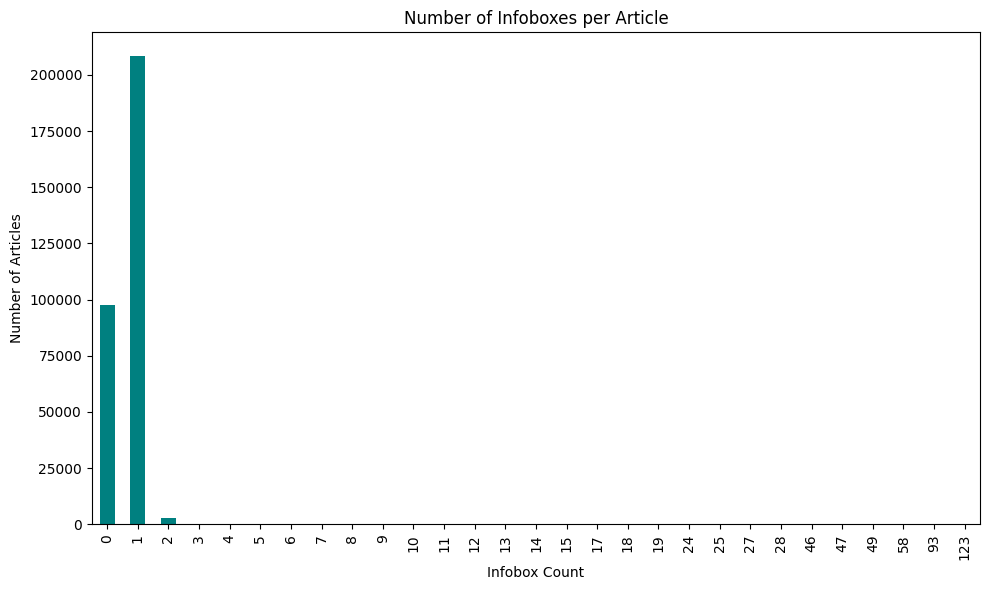

In [17]:
# Extract infobox types - fixed version
def count_infoboxes(infobox_str):
    if isinstance(infobox_str, list) or isinstance(infobox_str, np.ndarray):
        return len(infobox_str)
    if pd.isna(infobox_str) or infobox_str is None:
        return 0
    try:
        infoboxes = eval(infobox_str)
        return len(infoboxes)
    except:
        return 0

df['infobox_count'] = df['infoboxes'].apply(lambda x: count_infoboxes(x))

# Plot infobox count distribution
plt.figure(figsize=(10, 6))
df['infobox_count'].value_counts().sort_index().plot(kind='bar', color='teal')
plt.title('Number of Infoboxes per Article')
plt.xlabel('Infobox Count')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

##  Content Complexity Analysis

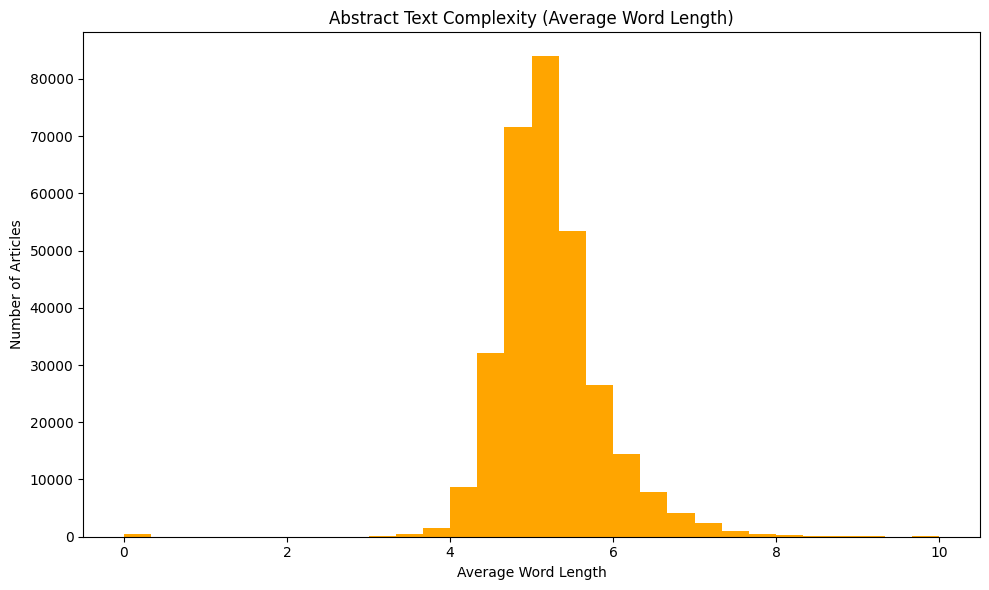

In [18]:
# Add columns for complexity metrics
def calculate_complexity(text):
    if not isinstance(text, str) or not text:
        return 0
    words = text.split()
    word_count = len(words)
    if word_count == 0:
        return 0
    avg_word_length = sum(len(word) for word in words) / word_count
    return avg_word_length

df['abstract_complexity'] = df['abstract'].apply(calculate_complexity)

# Plot complexity distribution
plt.figure(figsize=(10, 6))
plt.hist(df['abstract_complexity'].clip(0, 10), bins=30, color='orange')
plt.title('Abstract Text Complexity (Average Word Length)')
plt.xlabel('Average Word Length')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

## Description Distribution

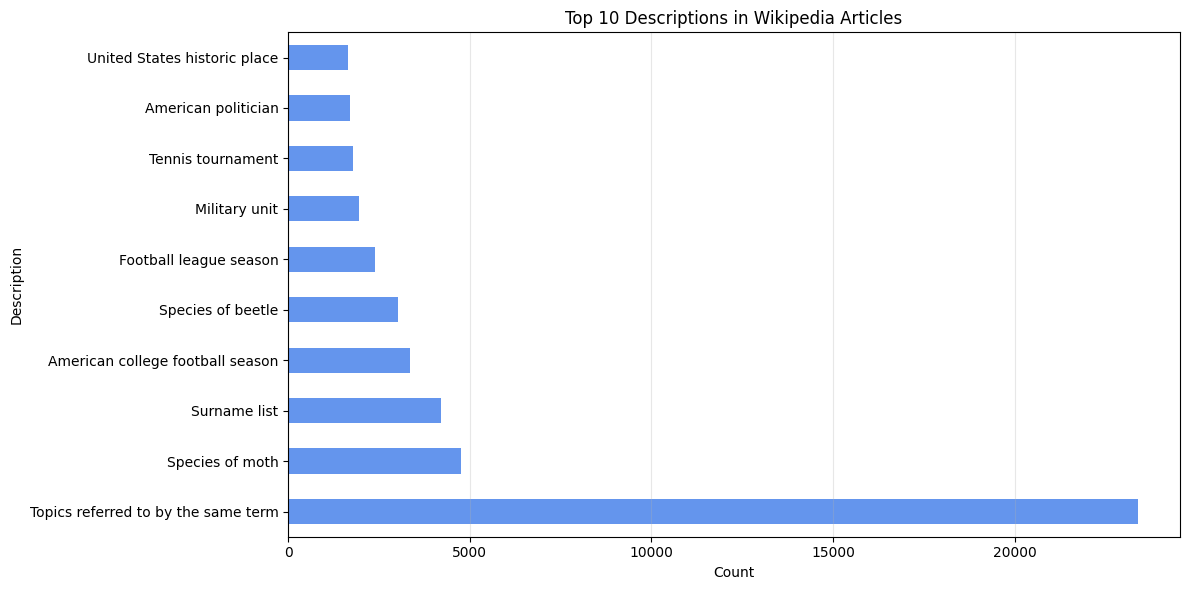

In [19]:
# Analyze description distribution
plt.figure(figsize=(12, 6))

# Get the top 10 descriptions by frequency
description_counts = df['description'].value_counts().head(10)

# Plot the top 10 descriptions
description_counts.plot(kind='barh', color='cornflowerblue')
plt.title('Top 10 Descriptions in Wikipedia Articles')
plt.xlabel('Count')
plt.ylabel('Description')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

In [8]:
tennis_results = df[df['description'].str.contains('tennis event result', case=False, na=False)]

# Display the results
print(tennis_results)

                            name  identifier                   version  \
171     1906 Wimbledon Champi...    10956381  {'identifier': 116472...   
247     1969 Buenos Aires ten...    19112521  {'identifier': 111467...   
390     1905 Australasian Cha...    10956098  {'identifier': 114345...   
432     1992 Volvo Women's Op...    75508922  {'identifier': 118878...   
530     1906 Wimbledon Champi...    31446150  {'identifier': 115943...   
...                          ...         ...                       ...   
309387  2022 Karlsruhe Open –...    70742060  {'identifier': 119782...   
309394  2004 US Open – Men's ...    49432525  {'identifier': 109747...   
309421  2017 L'Open Emeraude ...    55259103  {'identifier': 119782...   
309480  2021 Abierto Zapopan ...    67034425  {'identifier': 118111...   
309508  2000 IGA SuperThrift ...    57215534  {'identifier': 118753...   

                           event                       url date_created  \
171     {'identifier': 'f84e8...  ht

## Plot counts of descriptions that contain "Tennis Results"

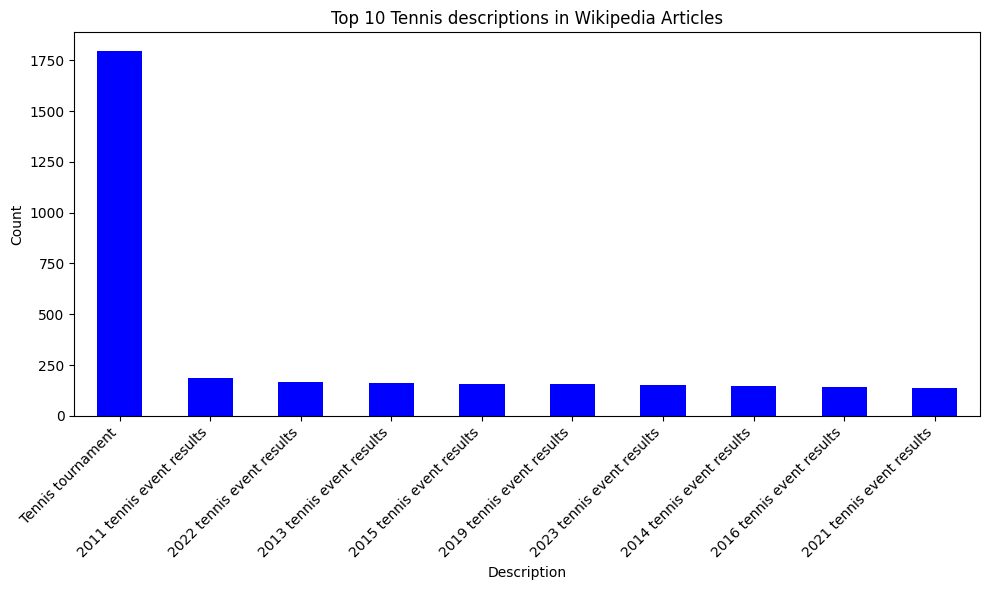

In [9]:

# Get tennis-related rows
tennis_results = df[df['description'].str.contains('Tennis', case=False, na=False)]

# Get the top 10 descriptions by frequency
tennis_counts = tennis_results['description'].value_counts().head(10)

# Plot the top 10 tennis descriptions
plt.figure(figsize=(10, 6))
tennis_counts.plot(kind='bar', color='blue')
plt.title('Top 10 Tennis descriptions in Wikipedia Articles')
plt.xlabel('Description')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##  Word Cloud of Article Names

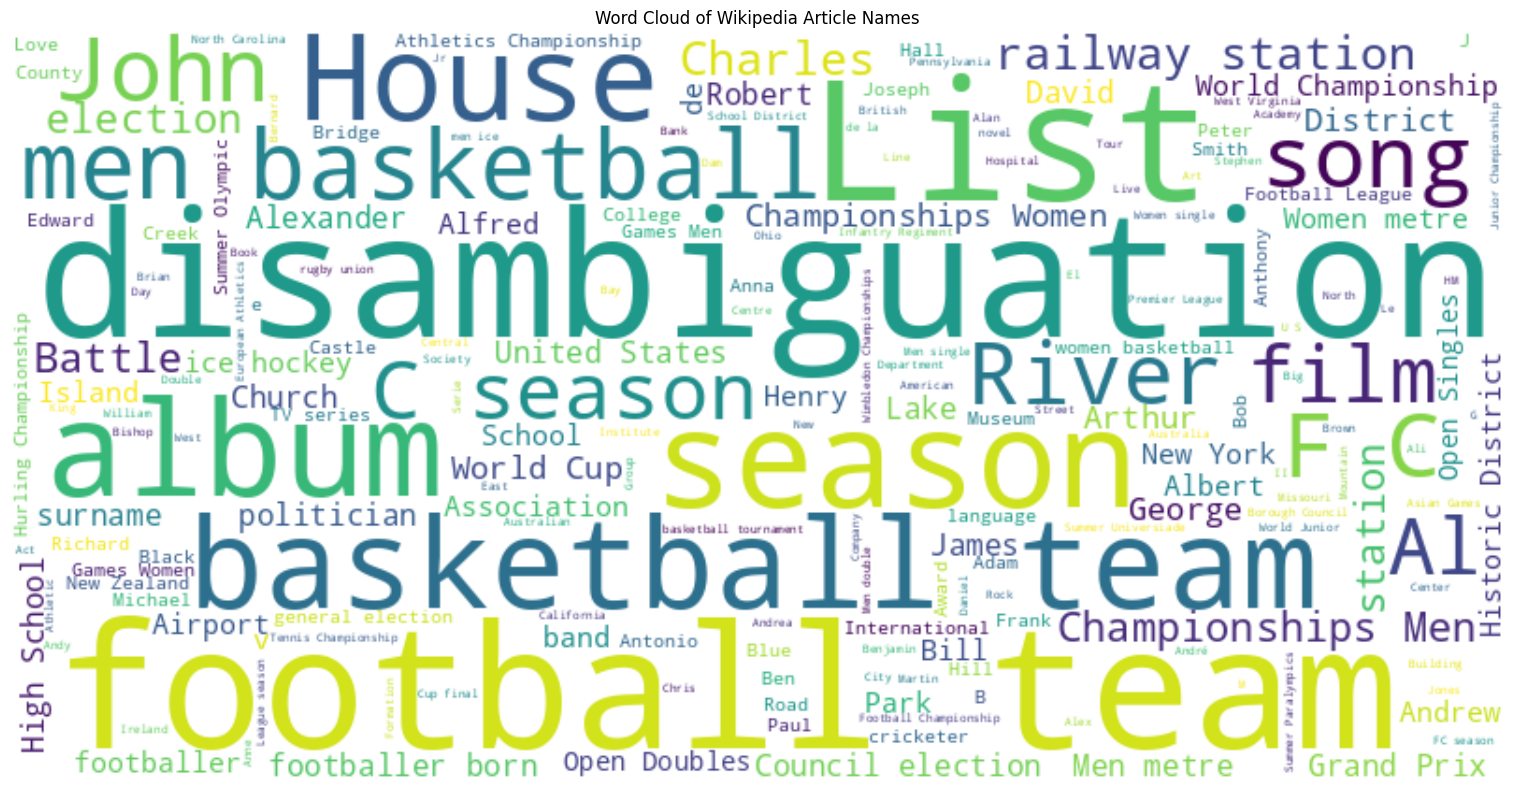

In [20]:
from wordcloud import WordCloud

# Create word cloud of article names
text = ' '.join(df['name'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Wikipedia Article Names')
plt.tight_layout()
plt.show()